<a href="https://colab.research.google.com/github/hsingh8015/project3_imageclassification/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image
import pandas as pd
import requests
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Read the CSV file using the correct path
bird_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FinalProject/warbler_image_labels.csv")

# Set the image path
image_path = "/content/drive/MyDrive/Colab Notebooks/FinalProject/New_Warbler_images"

bird_df.head()

Mounted at /content/drive


,filename,label
0,Image_1.jpg,158.Bay_breasted_Warbler
1,Image_2.jpg,158.Bay_breasted_Warbler
2,Image_3.jpg,158.Bay_breasted_Warbler
3,Image_4.jpg,158.Bay_breasted_Warbler
4,Image_5.jpg,158.Bay_breasted_Warbler


<ipython-input-3-7c4dea3fc1b6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes.index, y=classes.values, palette='plasma')


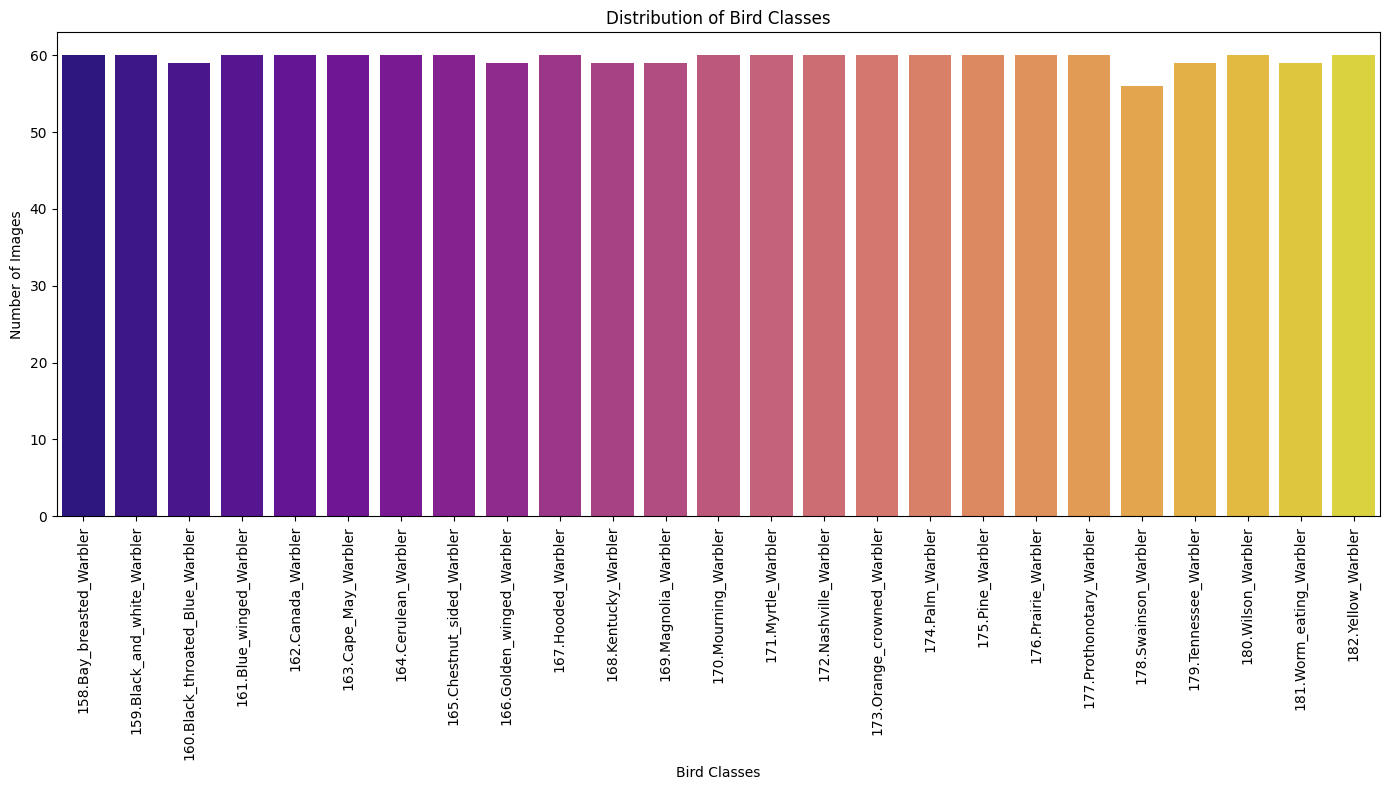

In [3]:
classes = bird_df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=classes.index, y=classes.values, palette='plasma')
plt.title('Distribution of Bird Classes')
plt.xlabel('Bird Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
images = []


for i in range(len(bird_df)):
    filename = bird_df.iloc[i, 0]
    path = os.path.join(image_path, filename)
    print(f'{i + 1} of {len(bird_df)}: Attempting to import {filename}')

    if not os.path.exists(path):
        print(f'FAILED: {filename} does not exist at {path}')
        continue

    try:
        # Use context manager to automatically close the file after opening
        with Image.open(path) as img:
            img = img.convert("RGB")  # Standardize to RGB
            images.append(img.copy())  # Append a copy of the image to close original
    except (IOError, SyntaxError, OSError) as e:
        print(f'FAILED to import {filename} at index {i + 1}, Error: {e}')

1 of 1490: Attempting to import Image_1.jpg
2 of 1490: Attempting to import Image_2.jpg
3 of 1490: Attempting to import Image_3.jpg
4 of 1490: Attempting to import Image_4.jpg
5 of 1490: Attempting to import Image_5.jpg
6 of 1490: Attempting to import Image_6.jpg
7 of 1490: Attempting to import Image_7.jpg
8 of 1490: Attempting to import Image_8.jpg
9 of 1490: Attempting to import Image_9.jpg
10 of 1490: Attempting to import Image_10.jpg
11 of 1490: Attempting to import Image_11.jpg
12 of 1490: Attempting to import Image_12.jpg
13 of 1490: Attempting to import Image_13.jpg
14 of 1490: Attempting to import Image_14.jpg
15 of 1490: Attempting to import Image_15.jpg
16 of 1490: Attempting to import Image_16.jpg
17 of 1490: Attempting to import Image_17.jpg
18 of 1490: Attempting to import Image_18.jpg
19 of 1490: Attempting to import Image_19.jpg
20 of 1490: Attempting to import Image_20.jpg
21 of 1490: Attempting to import Image_21.jpg
22 of 1490: Attempting to import Image_22.jpg
23 of 

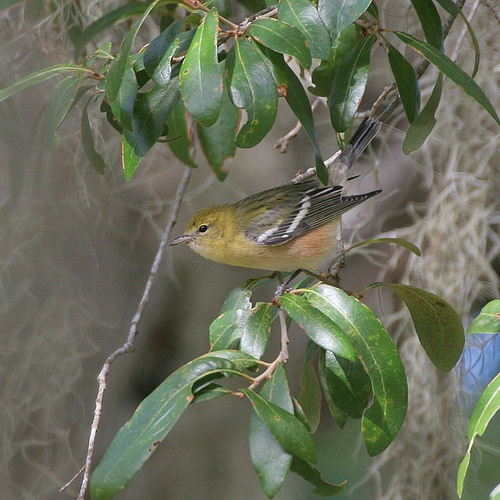

In [6]:
images[45]

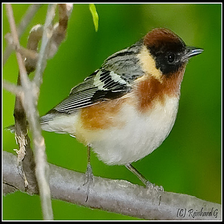

In [29]:
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes
# Use a for loop to resize all images to 224
target_size = (224, 224)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[4]

In [30]:
float_images = [np.array(img).astype(np.float32) for img in resized_images]

# Display the pixel values of the first image
print("Pixel Values:")
print(float_images[0])

Pixel Values:
[[[172. 164. 159.]
  [170. 169. 163.]
  [173. 186. 175.]
  ...
  [101. 126.  34.]
  [100. 128.  35.]
  [ 99. 128.  35.]]

 [[168. 161. 158.]
  [181. 177. 175.]
  [181. 181. 172.]
  ...
  [100. 125.  33.]
  [101. 126.  34.]
  [102. 128.  36.]]

 [[174. 166. 160.]
  [176. 173. 166.]
  [189. 185. 184.]
  ...
  [101. 126.  34.]
  [101. 127.  34.]
  [101. 129.  35.]]

 ...

 [[ 82. 170.  39.]
  [ 86. 172.  42.]
  [ 87. 171.  42.]
  ...
  [125. 208.  74.]
  [125. 209.  78.]
  [124. 211.  79.]]

 [[ 86. 171.  43.]
  [ 89. 171.  43.]
  [ 92. 174.  46.]
  ...
  [124. 209.  73.]
  [124. 210.  72.]
  [124. 211.  74.]]

 [[ 88. 172.  43.]
  [ 92. 173.  45.]
  [ 92. 173.  44.]
  ...
  [122. 209.  71.]
  [124. 209.  75.]
  [125. 211.  80.]]]


In [31]:
# To normalize images to a range between 0 and 1,
# we need to divide all pixel values by the max of 255

normalized_images = [img/255 for img in float_images]

# Display the pixel values of the first image
print("Pixel Values:")
print(normalized_images[0])

Pixel Values:
[[[0.6745098  0.6431373  0.62352943]
  [0.6666667  0.6627451  0.6392157 ]
  [0.6784314  0.7294118  0.6862745 ]
  ...
  [0.39607844 0.49411765 0.13333334]
  [0.39215687 0.5019608  0.13725491]
  [0.3882353  0.5019608  0.13725491]]

 [[0.65882355 0.6313726  0.61960787]
  [0.70980394 0.69411767 0.6862745 ]
  [0.70980394 0.70980394 0.6745098 ]
  ...
  [0.39215687 0.49019608 0.12941177]
  [0.39607844 0.49411765 0.13333334]
  [0.4        0.5019608  0.14117648]]

 [[0.68235296 0.6509804  0.627451  ]
  [0.6901961  0.6784314  0.6509804 ]
  [0.7411765  0.7254902  0.72156864]
  ...
  [0.39607844 0.49411765 0.13333334]
  [0.39607844 0.49803922 0.13333334]
  [0.39607844 0.5058824  0.13725491]]

 ...

 [[0.32156864 0.6666667  0.15294118]
  [0.3372549  0.6745098  0.16470589]
  [0.34117648 0.67058825 0.16470589]
  ...
  [0.49019608 0.8156863  0.2901961 ]
  [0.49019608 0.81960785 0.30588236]
  [0.4862745  0.827451   0.30980393]]

 [[0.3372549  0.67058825 0.16862746]
  [0.34901962 0.6705882

In [32]:
bird_df['filename'] = bird_df['filename'].str.replace('.jpg', '', regex=False)
bird_df.head()

,filename,label
0,Image_1,158.Bay_breasted_Warbler
1,Image_2,158.Bay_breasted_Warbler
2,Image_3,158.Bay_breasted_Warbler
3,Image_4,158.Bay_breasted_Warbler
4,Image_5,158.Bay_breasted_Warbler


In [33]:
# Now we can call our preprocessed pixel data 'X'
X = normalized_images

# For our purposes, we'll select the label column as 'y'
y = bird_df['label']

In [34]:
# Check the total number of classes
y.nunique()

25

In [35]:
X = np.array(X)
y = np.array(y)

In [36]:
# Now we'll split our data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [37]:
# Apply augmentation to the whole training dataset
# Define the augmentation pipeline

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),         # Rotate by 10%
    tf.keras.layers.RandomTranslation(0.15, 0.15), # Shift horizontally and vertically by 15%
    tf.keras.layers.RandomZoom(0.1),             # Zoom in/out by 10%
    tf.keras.layers.RandomFlip('horizontal')     # Random horizontal flip
])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]

    # Ensure that the input data has the correct shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 5 images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))

5585
5585


In [38]:
# Reshape test data for the model
X_test_np = []
for img in X_test:
    # Append the image to the list
    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[0].shape

(224, 224, 3)

In [39]:
# One hot encode the y data
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))

# Convert values to numpy arrays
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)

# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.2, random_state=42)

# Print the total number of one_hot_encoded columns
np.array(y_train).shape

(4468, 25)

In [56]:
import json
class_order = y_encoder.categories_[0].tolist()
with open('class_order.json', 'w') as f:
    json.dump(class_order, f)

In [44]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,  # Start with a smaller learning rate
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitors validation loss
    patience=20,                  # Stops if no improvement in 20 epochs
    restore_best_weights=True    # Restores best weights if stopped early
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,  # Reduce LR if no improvement for 2 epochs
    min_lr=1e-6
)

In [45]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),

    # New additional layer block
    layers.Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    layers.Dense(25, activation='softmax')
])

# Define early stopping with patience of 3 epochs
model.compile(optimizer=Adam(learning_rate=0.001),  # Set a fixed initial learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train with both early stopping and reduce_lr
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Increased to 50 epochs
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]  # Now you can use `reduce_lr`
)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.0607 - loss: 3.9210 - val_accuracy: 0.0349 - val_loss: 6.0917 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1019 - loss: 3.4190 - val_accuracy: 0.0421 - val_loss: 4.3656 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1668 - loss: 2.9176 - val_accuracy: 0.0752 - val_loss: 3.8335 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2171 - loss: 2.6188 - val_accuracy: 0.1334 - val_loss: 3.1447 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2489 - loss: 2.4602 - val_accuracy: 0.1603 - val_loss: 2.8363 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3060 - loss: 2.2487 - val_accuracy: 0.2104 - val_loss: 2.5950 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3674 - loss: 2

In [46]:
#evaluate the model
model.evaluate(X_test_np, y_test_np)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.2337 - loss: 2.8379


[2.9532880783081055, 0.2278820425271988]

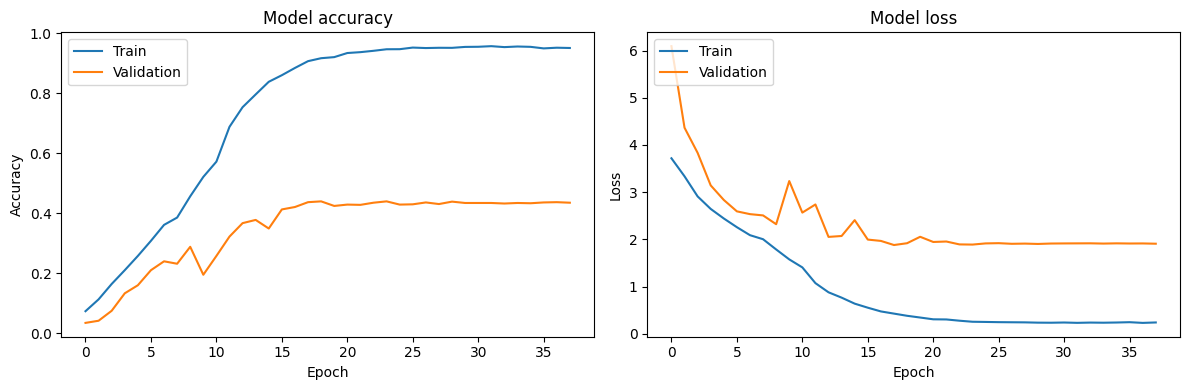

In [47]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [53]:
model = model.save('warbler_model.keras')


In [55]:
files.download('warbler_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>